## Modeling of Acoustic Scattering by a Cylindrical Obstacle in an Infinite Domain

In [1]:
import numpy as np
from scat_circ import u_exact_calc
from scat_circ import mask_displacement
from scat_circ import plot_displacement_amplitude
from scat_circ import plot_mesh_from_file
from scat_circ import measure_execution_time
from scat_circ import process_onelab_data
from scat_circ import plot_fem_results
from scat_circ import interpolate_fem_data
from scat_circ import calc_error

#### Parameters of the model

- $ r_i$: Inner radius [m].
- $ r_e$: Outer radius [m].
- $ r_a$: Radius of the outermost layer [m].
- $ k$: Wave number [a.u.].

In [2]:
r_i = 1.0 # Inner radius
r_e = 10.0 # Outer radius
r_a = 11 # Radius of the outermost layer
k = 1.0  # Wave number
n_grid = 501 # Number of grid points in x and y 

### Analytical Solution

In [3]:
# Create meshgrid for r and theta
Y_exact, X_exact = np.mgrid[-r_e:r_e:n_grid*1j, -r_e:r_e:n_grid*1j] 
R_exact = np.sqrt(X_exact**2 + Y_exact**2) 
Theta_exact = np.arctan2(Y_exact, X_exact)

# Calculate the displacement
u_scn_amp_exact, u_amp_exact = u_exact_calc(R_exact, Theta_exact, r_i, k, nmax=None)  # Calculate the displacement

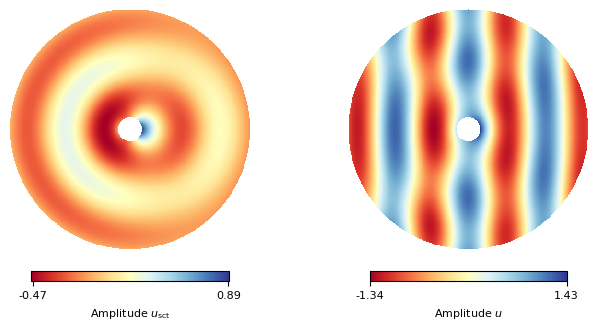

In [4]:
# Mask the displacement
u_amp_exact, u_scn_amp_exact = mask_displacement(R_exact, r_i, r_e, u_amp_exact, u_scn_amp_exact)

# Plot the displacement amplitude
plot_displacement_amplitude(X_exact, Y_exact, u_scn_amp_exact, u_amp_exact)

### Finite Element Method (FEM)

#### Mesh

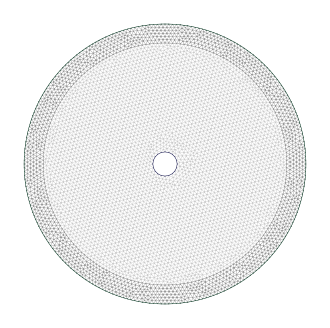

Nodes = 5181, Physical Domain Connections = 11228, Absorbing Layer Connections = 4164


In [5]:
# plot the mesh from the file
file_path_msh = "AcousticScattering/scattering.msh"
num_nodes, num_connections_P, num_connections_A = plot_mesh_from_file(file_path_msh)

# You can use the returned values for further processing
print(f"Nodes = {num_nodes}, Physical Domain Connections = {num_connections_P}, Absorbing Layer Connections = {num_connections_A}") 

#### FEM solution

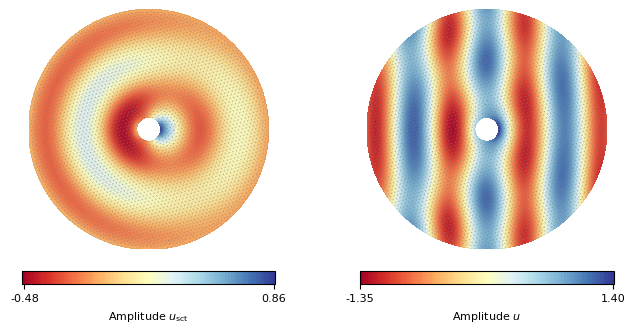

In [6]:
# data u_scn
file_path_u_scn = "AcousticScattering/u.pos"
X_fem, Y_fem, elements_fem, uscn_amp_fem = process_onelab_data(file_path_u_scn)

# data u
file_path_u = "AcousticScattering/u_Total.pos"
_, _, _, u_amp_fem = process_onelab_data(file_path_u)

# Show the FEM results
plot_fem_results(X_fem, Y_fem, elements_fem, uscn_amp_fem, u_amp_fem)

#### Accuracy

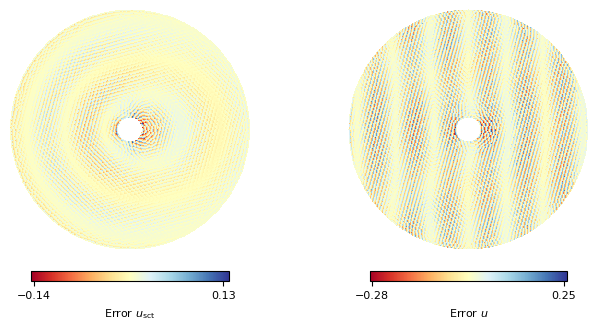

Relative error for u_scn: 2.70e-02
Relative error for u: 3.36e-02


In [7]:
# Interpolate the FEM data
X_grid, Y_grid, u_amp_interp_fem, uscn_amp_interp_fem = interpolate_fem_data(X_fem, Y_fem, u_amp_fem, uscn_amp_fem, r_i, r_e, n_grid)

# Plot difference and calculate relative error
rel_error_uscn, rel_error_u = calc_error(X_grid, Y_grid, u_scn_amp_exact, u_amp_exact, uscn_amp_interp_fem, u_amp_interp_fem, r_i, r_e)    

# Print the relative error in scientific notation
print(f"Relative error for u_scn: {rel_error_uscn:.2e}")
print(f"Relative error for u: {rel_error_u:.2e}")

#### Computation time

In [8]:
# Define the path to the getdp executable (this can be changed per machine)
getdp_path = "/home/orincon/onelab-Linux64/getdp"

# Define the rest of the command arguments to solve the model using getdp
command_args = "AcousticScattering/scattering.pro -solve Scattering -pos Wave -v2"

# Number of runs to measure statistically
num_runs = 10  # You can change this based on how many runs you want

# Example usage
average_time, std_dev_time, min_time, max_time = measure_execution_time(getdp_path, command_args, num_runs)
print(f"Statistical Measurement of Execution Time (over {num_runs} runs):")
print(f"Average Time: {average_time:.2f} seconds")
print(f"Standard Deviation: {std_dev_time:.2f} seconds")
print(f"Minimum Time: {min_time:.2f} seconds")
print(f"Maximum Time: {max_time:.2f} seconds")

Statistical Measurement of Execution Time (over 10 runs):
Average Time: 0.46 seconds
Standard Deviation: 0.02 seconds
Minimum Time: 0.42 seconds
Maximum Time: 0.49 seconds


### Physics informed neural networks (PINNs)